In [1]:
# sudoku.csv - https://www.kaggle.com/bryanpark/sudoku
# test_sudoku.csv - https://github.com/Kyubyong/sudoku/blob/master/data/test.csv

In [1]:
import seaborn as sns
import numpy as np
import scipy as sp
import pandas as pd

# good default imports 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore') 
%matplotlib inline

import pylab 
pylab.rcParams['figure.figsize'] = 10, 7


import collections
import torch
import torch.cuda
from torch.autograd import Variable
import torch.nn.functional as F
import time

In [2]:
import logging
# Create a custom logger


import os
import time
import datetime
import logging

loggers = {}

def get_logger(name='torch_sudoku'):
    global loggers

    if loggers.get(name):
        return loggers.get(name)
    else:
        logger = logging.getLogger(name)
        
        # Create handlers

        #c_handler = logging.StreamHandler()
        f_handler = logging.FileHandler('torch_sudoku.log')
        #c_handler.setLevel(logging.INFO)
        f_handler.setLevel(logging.INFO)

        # Create formatters and add it to handlers
        f_format = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
        #c_handler.setFormatter(f_format)
        f_handler.setFormatter(f_format)

        #logger.addHandler(c_handler)
        logger.addHandler(f_handler)
        logger.setLevel(logging.INFO)
        logger.info('Initialized =======================')
        loggers[name] = logger

        return logger







In [3]:
logger = get_logger()

In [4]:
import sys
sys.path.append(".")
import sudoku_solver as sudoku

from helper_functions import *
from sudoku_networks import *

In [5]:
file_name = 'data/sudoku.csv'
#eval_file_name = 'sudoku_eval.dat'

with open(file_name, 'r') as f:
    puz_x, puz_y = get_x_y(f, batches=1)

input_size = len(puz_x[0])
output_size = len(puz_y[0])

# based on literature
hidden_size = int(output_size + (2. / 3. * input_size) * 1.5) 

print(input_size)
print(output_size)
print(hidden_size)

729
729
1458


In [6]:
class TargetMultiLabelSoftMarginLoss(object):
    
    def __init__(self):
    
        self.loss = torch.nn.MultiLabelSoftMarginLoss(reduce=False)
    
    def __call__(self, y_pred, y):
        t = y.reshape((-1, 9, 81))
        
        
        
        t = t.transpose(1, 2).sum(2).reshape(-1,81)

        #t = torch.concatenate([t,t,t,t,t,t,t,t,t],-1) == 0
        t = t.repeat(1, 9) == 0

        #random non masked words need to be predicted

        #t = t | np.random.choice([True, False], (t.shape[0], 729), p=[0.1, 0.9])
        t = t | (torch.rand(t.shape[0], 729) < 0.1).type(torch.cuda.ByteTensor)

        return self.loss(
            y_pred * t.type(torch.cuda.FloatTensor), 
            y * t.type(torch.cuda.FloatTensor)
        )
    def __str__(self):
        return 'TargetMultiLabelSoftMarginLoss()'

In [7]:
scale = 1
num_examples = int(999000/scale)

#epochs = int(np.ceil(5.0/scale))

batch_size = int(128*2)

test_data = next(FileTrainingData(file_name, 0, 400))

parameters = [  
    {
        'models': [
            #lambda: ResListModule(
            #    ConvNet(3, ResidualConvBlock, 220, 0.1, True), 
            #    ConvNet(3, ResidualConvBlock, 220, 0.1, True)
            #)
            #lambda: ConvNet(3, ResidualConvBlock, 220, 0.1, True),
            
            #recursive_convnet,
    
            #lambda: SoftmaxModule(SumModel(
            #    LinearModel(729, 729),
            #    ConvNet(3, ResidualConvBlock, 220, dropout_prob, True)
            #)), 
            
            #lambda: SumModel(
            #    LinearModel(729, 729),
            #    ConvNet(3, ResidualConvBlock, 220, dropout_prob, True)
            #), 
            
            #lambda: NewConvNet(25, ResidualConvBlock, 220, dropout_prob, True),
            lambda: SumModel(
                LinearModel(729, 729),
                ConvNet(20, ResidualConvBlock, 240, 0.2, False)
            ),
            #lambda: LinearModel(729, 729),
            
                           
        ],
        'training_data': lambda: FileTrainingData(file_name, 400, 128), 
        'test_data': lambda: test_data, 
        # 'loss_fn': lambda: torch.nn.MultiLabelSoftMarginLoss(reduce=False), 
        'loss_fn': lambda: TargetMultiLabelSoftMarginLoss(),
        'optimizer': lambda model: torch.optim.Adam(model.parameters(), lr=0.001), 
        'epochs': 30
    }    
    
     
]

In [8]:
from tqdm import tqdm

In [9]:
trainers=[]
for param in parameters:
    for i, model in enumerate(param['models']):
        model = model()

        torch.cuda.empty_cache()

        model.cuda()

        optimizer = param['optimizer'](model)

        loss_fn = param['loss_fn']()

        training_data = param['training_data']()

        trainer = Trainer(
            model, 
            training_data, 
            test_data, 
            loss_fn, 
            optimizer
        )

        for _ in tqdm(range(param['epochs'])):
            trainer.train_step()

        lr, tr = trainer.loss_results, trainer.time_results

        logger.info('=======================')
        logger.info(f'{str(trainer)}')

        r = eval_and_score_puzzle(
            trainer.model, 
            'data/test_sudoku.csv', 
            predict_puzzle)
        trainer.r = r
        logger.info('=======================')

        logger.info(f'Avg Score: {np.mean([v[0] / v[1] for v in r])}')
        logger.info(f'Num Correct: {np.sum([v[0] for v in r])}')
        logger.info(f'Num Chances: {np.sum([v[1] for v in r])}')
        logger.info(f'Scores: {[v[0] / v[1] for v in r]}')
        logger.info(f'Results: {[(v[0], v[1]) for v in r]}')


        torch.save(trainer, f'{str(hash(str(trainer)))}.trainer')

        

100%|██████████| 30/30 [12:43:35<00:00, 1527.53s/it]  


In [10]:
disk_mods = !ls ./*.trainer
trainers = []

for i, trainer_name in enumerate(disk_mods):
    try:
        trainer = torch.load(trainer_name)
        trainers.append(trainer)
    except:
        pass

In [11]:
trainers = sorted(trainers, key=lambda x: x.loss_results[-1])

In [12]:
#disk_mods = !ls ./*.mdl
def show_results(trainers):
    pylab.rcParams['figure.figsize'] = 15, 8
    for i, trainer in enumerate(trainers):
        model = trainer.model
        
            
        try:
            m_name = str(model)
            lr, tr, ev = trainer.loss_results, trainer.time_results, trainer.r

            plt.plot(lr, label=str(i)+' '+m_name[:30])

            plt.legend(loc='top')
            #plt.ylim(0, 140)

            print(str(i)+' '+str(trainer))
            print(lr[-1])
            print(np.mean([v[0] / v[1] for v in ev]))
            print('')
        except:
            pass


0 SumModel LinearModel 729 729 ConvNet hidden_layers:20 conv_block:<class 'sudoku_networks.ResidualConvBlock'> num_filters:240 is_large:False dropout_prob:0.2
	epochs:30
	FileTrainingData data/sudoku.csv 400 128
	MultiLabelSoftMarginLoss()
	Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
0.04343150928616524
0.7408260663829136

1 ConvNet hidden_layers:30 conv_block:<class 'sudoku_networks.ResidualConvBlock'> num_filters:250 is_large:False dropout_prob:0.1
	epochs:5
	FileTrainingData data/sudoku.csv 400 128
	MultiLabelSoftMarginLoss()
	Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
0.239690899848938
0.739169143605423

2 ConvNet hidden_layers:20 conv_block:<class 'sudoku_networks.ResidualConvBlock'> num_filters:220 is_large:False dropout_prob:0.8
	epochs:30
	FileTrainingData data/sudoku.csv 400 128
	MultiLabelSoftMarginLoss()
	Adam (
Parameter Grou

(0, 20)

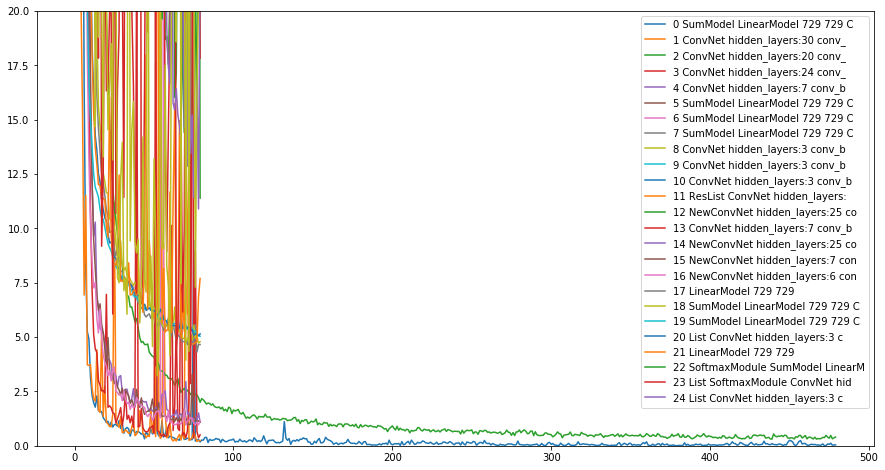

In [13]:
show_results(trainers)
plt.ylim(0,20)

In [28]:
kaggle_puz = []
kaggle_sln = []
for i, line in enumerate(open('data/test_sudoku.csv', 'r').read().splitlines()):
    try:
        quiz, solution = line.split(",")
        kaggle_puz.append([int(c) for c in quiz])
        kaggle_sln.append([int(c) for c in solution])
    except:
        pass


kaggle_puz = np.array(kaggle_puz).reshape((-1, 9, 9))
kaggle_sln = np.array(kaggle_sln).reshape((-1, 9, 9))

In [29]:
import sudoku

In [103]:
def eval_zeros(m):
    p = sudoku.create_matrix()
    arr = []
    for i in range(9):
        for j in range(9):
            arr.append(predict_cell(i,j, p, m))
    x = np.array(arr)[:,:,1]
    return np.percentile(x, 95) - np.percentile(x, 5)

In [104]:
str(trainers[4].model)

"ConvNet hidden_layers:7 conv_block:<class 'sudoku_networks.ResidualConvBlock'> num_filters:220 is_large:True dropout_prob:0.1"

In [105]:
str(trainers[0].model)

"SumModel LinearModel 729 729 ConvNet hidden_layers:20 conv_block:<class 'sudoku_networks.ResidualConvBlock'> num_filters:240 is_large:False dropout_prob:0.2"

In [106]:
eval_zeros(trainers[4].model)

0.40537853543646635

In [107]:
eval_zeros(trainers[0].model)

0.8165743054310675

In [111]:
for i in range(20):
    print(eval_zeros(trainers[i].model), str(trainers[i].model))
    print()

0.8165743054310675 SumModel LinearModel 729 729 ConvNet hidden_layers:20 conv_block:<class 'sudoku_networks.ResidualConvBlock'> num_filters:240 is_large:False dropout_prob:0.2

0.39222594136372213 ConvNet hidden_layers:30 conv_block:<class 'sudoku_networks.ResidualConvBlock'> num_filters:250 is_large:False dropout_prob:0.1

0.48393348005483866 ConvNet hidden_layers:20 conv_block:<class 'sudoku_networks.ResidualConvBlock'> num_filters:220 is_large:False dropout_prob:0.8

0.4457185095641762 ConvNet hidden_layers:24 conv_block:<class 'sudoku_networks.ResidualConvBlock'> num_filters:220 is_large:True dropout_prob:0.1

0.40537853543646635 ConvNet hidden_layers:7 conv_block:<class 'sudoku_networks.ResidualConvBlock'> num_filters:220 is_large:True dropout_prob:0.1

0.5865793522927564 SumModel LinearModel 729 729 ConvNet hidden_layers:7 conv_block:<class 'sudoku_networks.ResidualConvBlock'> num_filters:220 is_large:True dropout_prob:0.1

1.0 SumModel LinearModel 729 729 ConvNet hidden_layers:7

In [112]:


def predict_puzzle_simulate(puzzle, model, num_sims=10):
    
    num_zeros = np.sum(puzzle == 0)
    r = matrix_to_one_hot(puzzle)
    for _ in range(num_zeros):
        pred = simulate_solve(r, model, num_sims)
        
        r = pred + r
        
    r = one_hot_to_matrix(r)
    return r

def simulate_solve(puz, m, num_sims=100):
    puz = puz.copy()
    p = predict(puz, m)
    
    answers = []
    
    p = p / p.sum()
    
    selection = np.random.choice(np.arange(len(p)), p=p, size=num_sims)
    
    #selection = np.argsort(s)[-1*num_sims:]
    
    np.random.shuffle(selection)
    
    for s in selection:
        puz[selection] = 1
        
        #p = matrix_to_one_hot(predict_puzzle(one_hot_to_matrix(puz), m))
        answers.append(predict((puz), m))
        
        #answers += (p > 0.95)
        
        puz[selection] = 0
    
    #answers needs to get percentile b/c that is stable p20
    answers = np.percentile(np.array(answers), 20, axis=0)
    ret = np.zeros(len(p))
    ret[np.argmax(answers)] = 1
    return ret

In [16]:
# generate predictions for a given board state
# pick one at random as the assigned value
# recurse

In [113]:
def sudoku_walk(puz, m):
    if (puz.reshape(9,81).sum(0) > 0).sum() == 81:
        return puz
    else:
        p = predict(puz, m)
        p = p / p.sum()
        selection = np.random.choice(np.arange(len(p)), p=p, size=len(p))
        puz = puz.copy()
        puz[selection] = 1
        return sudoku_walk(puz, m)

In [114]:
def solve_sudoku_walk(puzzle, m):
    puz = matrix_to_one_hot(puzzle)
    
    while not (puz.reshape(9,81).sum(0) > 0).sum() == 81:
        
        walks = np.array([sudoku_walk(puz,m) for x in range(100)])

        walks = walks.sum(0) * (puz == 0)

        puz[np.argmax(walks)] = 1
    return one_hot_to_matrix(puz)

In [120]:
r = eval_and_score_puzzle(
                trainers[1].model, 
                'data/test_sudoku.csv', 
                solve_sudoku_walk)

In [121]:
r2 = eval_and_score_puzzle(
                trainers[1].model, 
                'data/test_sudoku.csv', 
                predict_puzzle)

In [119]:
print(np.mean([v[0] / v[1] for v in r]))
print(np.mean([v[0] / v[1] for v in r2]))

0.7489540752726686
0.7408260663829136


In [ ]:
def simulate_solve(puz, m, num_zeros, num_sims=100, answers = []):
    
    
    
    p = predict(puz, m)
    
    if num_zeros == 1:
        return [p]
    else:
        p = p / p.sum()
    
        selection = np.random.choice(num_sims, p=p, size=num_sims)
        puz = puz.copy()
        puz[selection] = 1
        
        simulate_solve(puz, m, num_zeros, num_sims=1, answers = [])
        
        #p = matrix_to_one_hot(predict_puzzle(one_hot_to_matrix(puz), m))
        answers.append(predict((puz), m))
        
        #answers += (p > 0.95)
        
        puz[selection] = 0
    
    #answers needs to get percentile b/c that is stable p20
    answers = np.percentile(np.array(answers), 20, axis=0)
    ret = np.zeros(len(p))
    ret[np.argmax(answers)] = 1
    return ret

In [41]:
k = np.array(simulate_solve(matrix_to_one_hot(kaggle_puz[6]),m, 50))

In [48]:
k = predict_puzzle_simulate(kaggle_puz[6], m, 50)

In [49]:
kaggle_sln[6]

array([[5, 7, 4, 9, 6, 1, 2, 3, 8],
       [9, 1, 8, 3, 2, 7, 5, 4, 6],
       [2, 6, 3, 8, 4, 5, 7, 9, 1],
       [6, 8, 2, 1, 3, 4, 9, 5, 7],
       [4, 3, 9, 5, 7, 6, 8, 1, 2],
       [7, 5, 1, 2, 8, 9, 4, 6, 3],
       [8, 9, 5, 6, 1, 2, 3, 7, 4],
       [1, 2, 7, 4, 5, 3, 6, 8, 9],
       [3, 4, 6, 7, 9, 8, 1, 2, 5]])

In [50]:
k 

array([[5, 7, 4, 9, 0, 1, 3, 2, 8],
       [9, 1, 8, 3, 7, 2, 5, 0, 6],
       [2, 6, 3, 8, 4, 5, 7, 9, 1],
       [6, 0, 2, 1, 0, 4, 9, 5, 7],
       [4, 3, 9, 0, 5, 0, 8, 1, 2],
       [7, 5, 1, 2, 0, 9, 4, 6, 3],
       [8, 9, 0, 4, 1, 6, 0, 7, 0],
       [1, 4, 7, 5, 2, 3, 6, 8, 9],
       [3, 2, 6, 7, 0, 8, 1, 0, 5]])

In [111]:
(j == kaggle_sln[6]).sum()

55

In [204]:
def eval_and_score_puzzle(model, file_name):
    kaggle_puz = []
    kaggle_sln = []
    for i, line in enumerate(open(file_name, 'r').read().splitlines()):
        try:
            quiz, solution = line.split(",")
            kaggle_puz.append([int(c) for c in quiz])
            kaggle_sln.append([int(c) for c in solution])
        except:
            pass


    kaggle_puz = np.array(kaggle_puz).reshape((-1, 9, 9))
    kaggle_sln = np.array(kaggle_sln).reshape((-1, 9, 9))

    scores = []
    for puz, sln in zip(kaggle_puz, kaggle_sln):
        p = predict_puzzle_recursive(puz, model)
        score = accuracy(sln, puz, p)
        scores.append(score)

    #print(scores)
    #print(np.mean(scores))
    #print('')
    return scores

In [206]:
scores = eval_and_score_puzzle(m, file_name)

KeyboardInterrupt: 

In [95]:
kaggle_puz[6]

array([[5, 0, 0, 9, 0, 1, 0, 0, 8],
       [0, 0, 8, 0, 0, 0, 5, 0, 0],
       [0, 6, 0, 0, 4, 0, 0, 9, 0],
       [6, 0, 0, 1, 0, 4, 0, 0, 7],
       [0, 0, 9, 0, 0, 0, 8, 0, 0],
       [7, 0, 0, 2, 0, 9, 0, 0, 3],
       [0, 9, 0, 0, 1, 0, 0, 7, 0],
       [0, 0, 7, 0, 0, 0, 6, 0, 0],
       [3, 0, 0, 7, 0, 8, 0, 0, 5]])

In [96]:
kaggle_sln[6]

array([[5, 7, 4, 9, 6, 1, 2, 3, 8],
       [9, 1, 8, 3, 2, 7, 5, 4, 6],
       [2, 6, 3, 8, 4, 5, 7, 9, 1],
       [6, 8, 2, 1, 3, 4, 9, 5, 7],
       [4, 3, 9, 5, 7, 6, 8, 1, 2],
       [7, 5, 1, 2, 8, 9, 4, 6, 3],
       [8, 9, 5, 6, 1, 2, 3, 7, 4],
       [1, 2, 7, 4, 5, 3, 6, 8, 9],
       [3, 4, 6, 7, 9, 8, 1, 2, 5]])

In [80]:
one_hot_to_matrix(recursive_solve(matrix_to_one_hot(kaggle_puz[6]), m) > 0)

array([[5, 7, 4, 9, 3, 1, 2, 6, 8],
       [9, 1, 8, 6, 7, 2, 5, 3, 4],
       [2, 6, 3, 8, 4, 5, 7, 9, 1],
       [6, 3, 5, 1, 8, 4, 9, 2, 7],
       [4, 2, 9, 3, 5, 7, 8, 1, 6],
       [7, 8, 1, 2, 6, 9, 4, 5, 3],
       [8, 9, 4, 5, 1, 6, 3, 7, 2],
       [1, 5, 7, 4, 2, 3, 6, 8, 9],
       [3, 2, 6, 7, 9, 8, 1, 4, 5]])

array([[5, 7, 4, 9, 6, 1, 2, 3, 8],
       [9, 1, 8, 3, 2, 7, 5, 4, 6],
       [2, 6, 3, 8, 4, 5, 7, 9, 1],
       [6, 8, 2, 1, 3, 4, 9, 5, 7],
       [4, 3, 9, 5, 7, 6, 8, 1, 2],
       [7, 5, 1, 2, 8, 9, 4, 6, 3],
       [8, 9, 5, 6, 1, 2, 3, 7, 4],
       [1, 2, 7, 4, 5, 3, 6, 8, 9],
       [3, 4, 6, 7, 9, 8, 1, 2, 5]])

In [52]:
predict(puz, m).sum()

1.0

In [50]:
s = s / s.sum()
selection = np.random.choice(np.arange(len(s)), p=s)

In [51]:
selection

182

In [24]:
r, p  = predict_puzzle_until_wrong(kaggle_puz[6], kaggle_sln[6], m)
#print(predict_puzzle(kaggle_puz[6], m))
print(r)
print(kaggle_sln[6])

print(kaggle_sln[6] == predict_puzzle(r, m))

[[ 5  0  0  9  0  1  0  0  8]
 [ 0  0  8  0  0  0  5  0  0]
 [ 0  6  0  8  4  0  7  9  0]
 [ 6  0  0  1  0  4  0  0  7]
 [ 0  0  9  0  0  0  8  0  0]
 [ 7 -8  0  2  0  9  0  0  3]
 [ 0  9  0  0  1  0  0  7  0]
 [ 0  0  7  0  0  0  6  8  0]
 [ 3  0  0  7  0  8  0  0  5]]
[[5 7 4 9 6 1 2 3 8]
 [9 1 8 3 2 7 5 4 6]
 [2 6 3 8 4 5 7 9 1]
 [6 8 2 1 3 4 9 5 7]
 [4 3 9 5 7 6 8 1 2]
 [7 5 1 2 8 9 4 6 3]
 [8 9 5 6 1 2 3 7 4]
 [1 2 7 4 5 3 6 8 9]
 [3 4 6 7 9 8 1 2 5]]
[[ True  True  True  True False  True  True False  True]
 [ True  True  True False False False  True False False]
 [ True  True  True  True  True  True  True  True  True]
 [ True False  True  True False  True  True  True  True]
 [ True False  True False False False  True False False]
 [ True False  True  True False  True  True False  True]
 [ True  True  True False  True False  True  True False]
 [ True False  True False False  True  True  True  True]
 [ True False  True  True  True  True  True False  True]]


In [81]:
puzzle = np.array([[ 5 , 0,  0,  9,  0,  1,  0,  0,  8],
 [0  ,0 , 8 , 0 , 0 , 0 , 5 , 0 , 0],
 [ 0  ,6,  0,  0,  4,  0,  0,  9,  0],
 [ 6  ,0,  0,  1,  0,  4,  0,  0,  7],
 [ 0  ,0,  9,  0,  0,  0,  8,  0,  0],
 [ 7  ,0,  0,  2,  0,  9,  0,  0,  3],
 [ 0  ,9,  0,  0,  1,  0,  0,  7,  0],
 [ 0  ,0,  7,  0,  0,  0,  6,  0,  0],
 [ 3  ,0,  0,  7,  0,  8,  0,  0,  5]
             ])

answer = kaggle_sln[6]

In [78]:
#one_hot_to_matrix(predict_best(), m))

In [94]:
answer

array([[5, 7, 4, 9, 6, 1, 2, 3, 8],
       [9, 1, 8, 3, 2, 7, 5, 4, 6],
       [2, 6, 3, 8, 4, 5, 7, 9, 1],
       [6, 8, 2, 1, 3, 4, 9, 5, 7],
       [4, 3, 9, 5, 7, 6, 8, 1, 2],
       [7, 5, 1, 2, 8, 9, 4, 6, 3],
       [8, 9, 5, 6, 1, 2, 3, 7, 4],
       [1, 2, 7, 4, 5, 3, 6, 8, 9],
       [3, 4, 6, 7, 9, 8, 1, 2, 5]])

In [74]:
kaggle_sln[6]

array([[5, 7, 4, 9, 6, 1, 2, 3, 8],
       [9, 1, 8, 3, 2, 7, 5, 4, 6],
       [2, 6, 3, 8, 4, 5, 7, 9, 1],
       [6, 8, 2, 1, 3, 4, 9, 5, 7],
       [4, 3, 9, 5, 7, 6, 8, 1, 2],
       [7, 5, 1, 2, 8, 9, 4, 6, 3],
       [8, 9, 5, 6, 1, 2, 3, 7, 4],
       [1, 2, 7, 4, 5, 3, 6, 8, 9],
       [3, 4, 6, 7, 9, 8, 1, 2, 5]])

In [65]:
r, p  = predict_puzzle_until_wrong(kaggle_puz[6], kaggle_sln[6], m)
#print(predict_puzzle(kaggle_puz[6], m))
print(r)
print(kaggle_sln[6])

print(kaggle_sln[6] == predict_puzzle(r, m))

[[ 5  0  0  9  0  1  0  0  8]
 [-9  0  8  0  0  0  5  0  0]
 [ 0  6  0  0  4  0  0  9  0]
 [ 6  0  0  1  0  4  0  0  7]
 [ 0  0  9  0  0  0  8  0  0]
 [ 7  0  0  2  0  9  0  0  3]
 [ 0  9  0  0  1  0  0  7  0]
 [ 0  0  7  0  0  0  6  0  0]
 [ 3  0  0  7  0  8  0  0  5]]
[[5 7 4 9 6 1 2 3 8]
 [9 1 8 3 2 7 5 4 6]
 [2 6 3 8 4 5 7 9 1]
 [6 8 2 1 3 4 9 5 7]
 [4 3 9 5 7 6 8 1 2]
 [7 5 1 2 8 9 4 6 3]
 [8 9 5 6 1 2 3 7 4]
 [1 2 7 4 5 3 6 8 9]
 [3 4 6 7 9 8 1 2 5]]
[[ True False  True  True False  True False False  True]
 [ True False  True  True  True False  True  True False]
 [False  True  True  True  True  True  True  True False]
 [ True  True False  True  True  True  True False  True]
 [False  True  True False False False  True  True False]
 [ True False  True  True  True  True False False  True]
 [False  True False False  True False False  True False]
 [False False  True  True False False  True False False]
 [ True False False  True False  True False False  True]]


In [57]:
r, p = predict_puzzle_until_wrong(kaggle_puz[6], kaggle_sln[6], m)
print(r)
print()
print(p)
print()
print(kaggle_sln[6])

[[ 5  0  0  9  0  1  0  0  8]
 [ 0  0  8  0  0  0  5  0 -1]
 [ 0  6  0  0  4  0  0  9  0]
 [ 6  0  0  1  0  4  0  0  7]
 [ 0  0  9  0  0  0  8  0  0]
 [ 7  0  0  2  0  9  0  0  3]
 [ 0  9  0  0  1  0  0  7  0]
 [ 0  0  7  0  0  0  6  0  0]
 [ 3  0  0  7  0  8  0  0  5]]

[[5 0 0 9 0 1 0 0 8]
 [0 0 8 0 0 0 5 0 0]
 [0 6 0 0 4 0 0 9 0]
 [6 0 0 1 0 4 0 0 7]
 [0 0 9 0 0 0 8 0 0]
 [7 0 0 2 0 9 0 0 3]
 [0 9 0 0 1 0 0 7 0]
 [0 0 7 0 0 0 6 0 0]
 [3 0 0 7 0 8 0 0 5]]

[[5 7 4 9 6 1 2 3 8]
 [9 1 8 3 2 7 5 4 6]
 [2 6 3 8 4 5 7 9 1]
 [6 8 2 1 3 4 9 5 7]
 [4 3 9 5 7 6 8 1 2]
 [7 5 1 2 8 9 4 6 3]
 [8 9 5 6 1 2 3 7 4]
 [1 2 7 4 5 3 6 8 9]
 [3 4 6 7 9 8 1 2 5]]


In [93]:
scores[6]

0.5094339622641509

In [87]:
print(predict_puzzle(kaggle_puz[6], ))
print()
print(kaggle_sln[6])

[[5 7 4 9 3 1 2 6 8]
 [9 1 8 6 7 2 5 3 4]
 [2 6 3 8 4 5 7 9 1]
 [6 3 5 1 8 4 9 2 7]
 [4 2 9 3 5 7 8 1 6]
 [7 8 1 2 6 9 4 5 3]
 [8 9 2 5 1 6 3 7 2]
 [1 5 7 4 2 3 6 8 9]
 [3 4 6 7 9 8 1 4 5]]

[[5 7 4 9 6 1 2 3 8]
 [9 1 8 3 2 7 5 4 6]
 [2 6 3 8 4 5 7 9 1]
 [6 8 2 1 3 4 9 5 7]
 [4 3 9 5 7 6 8 1 2]
 [7 5 1 2 8 9 4 6 3]
 [8 9 5 6 1 2 3 7 4]
 [1 2 7 4 5 3 6 8 9]
 [3 4 6 7 9 8 1 2 5]]


In [73]:
disk_mods = !ls *.mdl

for model_name in disk_mods:
    model = torch.load(model_name)
    model.cuda()
    print(str(model))
    z = [x*1.0/y for x,y in eval_and_score_puzzle(model, 'data/test_sudoku.csv')]
    print(np.average(z))
    print(z)
    print()



NetSharedLayer 0.1 729 729 729 False
0.6202714483136892
[0.8723404255319149, 1.0, 0.851063829787234, 0.6666666666666666, 1.0, 0.7608695652173914, 0.5094339622641509, 0.38181818181818183, 0.509090909090909, 0.6981132075471698, 0.5384615384615384, 0.7321428571428571, 0.35714285714285715, 0.5454545454545454, 0.4727272727272727, 0.5964912280701754, 0.36363636363636365, 0.5178571428571429, 0.4107142857142857, 0.6, 0.7962962962962963, 0.38181818181818183, 0.34545454545454546, 0.42592592592592593, 0.98, 0.66, 0.673469387755102, 0.49056603773584906, 1.0, 0.47058823529411764]



AttributeError: 'collections.OrderedDict' object has no attribute 'cuda'

In [68]:
m_name, lr, tr, model = big_conv_net_result

plt.plot(tr, lr, label='net')

plt.legend()

eval_and_score_puzzle(model)

NameError: name 'big_conv_net_result' is not defined

In [11]:
complex_net_shared = None
torch.cuda.empty_cache()

complex_net_shared = ComplexNetShared(hidden_size*2, dropout_prob, n_hidden=7)
complex_net_shared.cuda()



ComplexNetShared(
  (conv_channels): Linear(in_features=81, out_features=108, bias=True)
  (conv_rows): Linear(in_features=81, out_features=108, bias=True)
  (conv_cols): Linear(in_features=81, out_features=108, bias=True)
  (ops): ListModule(
    (0): Linear(in_features=2916, out_features=2916, bias=True)
    (1): BatchNorm1d(2916, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.2)
    (4): Linear(in_features=2916, out_features=2916, bias=True)
    (5): BatchNorm1d(2916, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Dropout(p=0.2)
    (8): Linear(in_features=2916, out_features=2916, bias=True)
    (9): BatchNorm1d(2916, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Dropout(p=0.2)
    (12): Linear(in_features=2916, out_features=2916, bias=True)
    (13): BatchNorm1d(2916, eps=

In [12]:
total_params(complex_net_shared)

61735689

In [ ]:
complex_net_shared_result = run_training(file_name, complex_net_shared, num_examples, 
                                         epochs, batch_size)  

[0.4444444444444444, 0.6170212765957447, 0.6888888888888889, 0.2978723404255319, 0.5869565217391305, 0.49056603773584906, 0.36363636363636365, 0.41818181818181815, 0.3018867924528302, 0.25, 0.4107142857142857, 0.6071428571428571, 0.21818181818181817, 0.32727272727272727, 0.49122807017543857, 0.18181818181818182, 0.2857142857142857, 0.23214285714285715, 0.38181818181818183, 0.35185185185185186, 0.32727272727272727, 0.45454545454545453, 0.42592592592592593, 0.48, 0.52, 0.5918367346938775, 0.32075471698113206, 0.5294117647058824, 0.37254901960784315]
0.41274606705744576



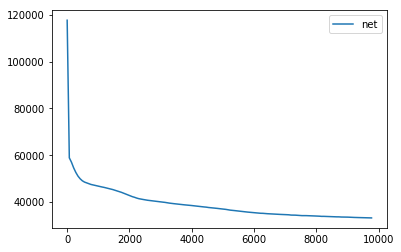

In [14]:
m_name, lr, tr, model = complex_net_shared_result

plt.plot(tr, lr, label='net')

plt.legend()

eval_and_score_puzzle(model)

In [4]:
m_name, lr, tr, model = complex_net_shared_result

plt.plot(tr, lr, label='net')

plt.legend()

eval_and_score_puzzle(model)

NameError: name 'complex_net_shared_result' is not defined

In [19]:
net_shared = None
torch.cuda.empty_cache()

net_shared = NetShared(hidden_size*2.5, dropout_prob, n_hidden=2)
net_shared.cuda()



NetShared(
  (conv): Linear(in_features=81, out_features=405, bias=True)
  (ops): ListModule(
    (0): Linear(in_features=3645, out_features=3645, bias=True)
    (1): BatchNorm1d(3645, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.2)
    (4): Linear(in_features=3645, out_features=3645, bias=True)
    (5): BatchNorm1d(3645, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Dropout(p=0.2)
    (8): Linear(in_features=3645, out_features=729, bias=True)
  )
)

In [20]:
total_params(net_shared)

29285064

In [21]:
net_shared_result = run_training(file_name, net_shared, num_examples, 
                                 epochs, batch_size)  

In [3]:
m_name, lr, tr, model = net_shared_result

plt.plot(tr, lr, label='net')

plt.legend()

eval_and_score_puzzle(model)

NameError: name 'net_shared_result' is not defined

In [15]:
t = torch.Tensor(np.arange(9*9))

t.reshape((9,9))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12., 13., 14., 15., 16., 17.],
        [18., 19., 20., 21., 22., 23., 24., 25., 26.],
        [27., 28., 29., 30., 31., 32., 33., 34., 35.],
        [36., 37., 38., 39., 40., 41., 42., 43., 44.],
        [45., 46., 47., 48., 49., 50., 51., 52., 53.],
        [54., 55., 56., 57., 58., 59., 60., 61., 62.],
        [63., 64., 65., 66., 67., 68., 69., 70., 71.],
        [72., 73., 74., 75., 76., 77., 78., 79., 80.]])

In [ ]:
t.reshape((9,9,9))

In [ ]:
t.permute(0, 1, 2)
t.permute(-1, 1, 0, 2)
t.permute(2, 0, 1)

In [11]:
t.permute(1, 0, 2)

tensor([[[0.4072, 0.5258, 0.3542, 0.3137],
         [0.4614, 0.6550, 0.6532, 0.5277]],

        [[0.6607, 0.8509, 0.4967, 0.4520],
         [0.5637, 0.9027, 0.8473, 0.4883]],

        [[0.1746, 0.1333, 0.6512, 0.1272],
         [0.7436, 0.3915, 0.6714, 0.9985]]])

In [15]:
shared_conv_net = None
torch.cuda.empty_cache()
shared_conv_net = SharedConvNet(7, 300, dropout_prob, True)
shared_conv_net.cuda()


total_params(shared_conv_net), countZeroWeights(shared_conv_net)

shared_conv_net_result = run_training(file_name, shared_conv_net, num_examples, epochs, batch_size)  

RuntimeError: CUDA error: out of memory

In [2]:
m_name, lr, tr, model = shared_conv_net_result

plt.plot(tr, lr, label='net')

plt.legend()

eval_and_score_puzzle(model)

NameError: name 'shared_conv_net_result' is not defined

In [1]:
_

''

In [6]:
conv_net = None
torch.cuda.empty_cache()
conv_net = ConvNet(8, 350, dropout_prob, True)
conv_net.cuda()
conv_net_result = run_training(file_name, conv_net, num_examples, epochs, batch_size)  

NameError: name 'torch' is not defined

In [7]:
total_params(conv_net)

29418729

[1.0, 1.0, 0.8666666666666667, 1.0, 1.0, 0.5849056603773585, 0.43636363636363634, 0.6545454545454545, 1.0, 0.5384615384615384, 0.35714285714285715, 0.75, 0.7454545454545455, 0.6909090909090909, 0.38596491228070173, 0.6727272727272727, 0.25, 0.5178571428571429, 0.45454545454545453, 0.6481481481481481, 0.38181818181818183, 0.8909090909090909, 0.37037037037037035, 0.8, 0.72, 0.9795918367346939, 0.2830188679245283, 0.8823529411764706, 0.803921568627451]
0.6781267323462296



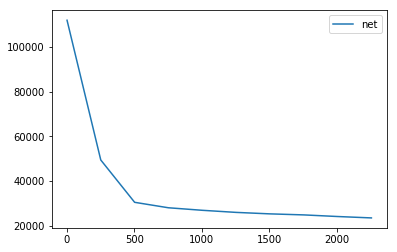

In [18]:
m_name, lr, tr, model = conv_net_result

plt.plot(tr, lr, label='net')

plt.legend()

eval_and_score_puzzle(model)

In [11]:
!rm completed_puz.csv

rm: cannot remove 'completed_puz.csv': No such file or directory


In [12]:
try_complete_sudoku('sudoku.csv', 'completed_puz.csv', model, 400000)

KeyboardInterrupt: 

In [ ]:

!cat sudoku.csv > sudoku_shuffle.csv
!cat completed_puz.csv >> sudoku_shuffle.csv
!shuf -o sudoku_shuffle_final.csv < sudoku_shuffle.csv

In [ ]:
!wc -l sudoku_shuffle.csv

In [ ]:
dropout_prob = 0.2
net_shared2 = NetShared(input_size, hidden_size*2, output_size, dropout_prob, n_hidden=2)
net_shared2.cuda()


num_examples = 900000


epochs = 10

batch_size = 100


net_shared_result2 = run_training('sudoku_shuffle_final.csv', net_shared2, num_examples, 
                                 epochs, batch_size)  

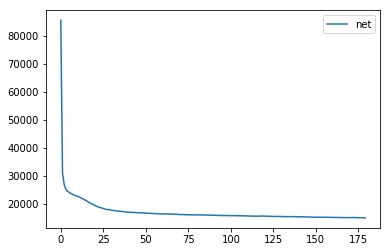

In [31]:
#plt.plot(logistic_result[1])
plt.plot(net_shared_result2[1], label='net')

plt.legend()

In [28]:
eval_and_score_puzzle(net_shared)

NetShared 0.2 729 2916 729 2 10 100
[1.0, 1.0, 1.0, 1.0, 1.0, 0.5094339622641509, 0.4, 0.6545454545454545, 0.39622641509433965, 0.7307692307692307, 0.32142857142857145, 0.5714285714285714, 1.0, 0.5818181818181818, 0.7894736842105263, 0.38181818181818183, 0.23214285714285715, 0.5535714285714286, 0.9272727272727272, 0.8703703703703703, 1.0, 0.6, 0.2962962962962963, 0.72, 1.0, 1.0, 0.6226415094339622, 1.0, 1.0]
0.7296288773263742



In [ ]:
# shared conv net - 0.7296288773263742 hidden layer x2, 2 layers

In [29]:
eval_and_score_puzzle(net_shared2)

NetShared 0.2 729 2916 729 2 10 100
[1.0, 1.0, 1.0, 1.0, 1.0, 0.39622641509433965, 0.509090909090909, 0.5454545454545454, 0.39622641509433965, 0.5192307692307693, 1.0, 0.6428571428571429, 0.8181818181818182, 0.45454545454545453, 0.43859649122807015, 0.34545454545454546, 0.26785714285714285, 0.39285714285714285, 0.38181818181818183, 0.8888888888888888, 1.0, 0.43636363636363634, 0.5740740740740741, 1.0, 1.0, 1.0, 0.5471698113207547, 1.0, 0.7450980392156863]
0.6999997042630153



In [10]:
class LogisticRegression(torch.nn.Module):
    def __init__(self):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(LogisticRegression, self).__init__()
        self.input_size = 9**3
        self.output_size = 9**3      
        
        self.combined_linear = torch.nn.Linear(input_size, output_size)

    def forward(self, x):
        """
        In the forward function we accept a Variable of input data and we must return
        a Variable of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Variables.
        """       
        y_pred = self.combined_linear(x)  
        
        return y_pred
    
    def __str__(self):
        return '{} {} {}'.format(
            type(self).__name__, 
            self.input_size, 
            self.output_size)

In [ ]:
model = net_shared2

kaggle_puz = []
kaggle_sln = []
for i, line in enumerate(open('test_sudoku.csv', 'r').read().splitlines()[1:]):
    quiz, solution = line.split(",")
    kaggle_puz.append([int(c) for c in quiz])
    kaggle_sln.append([int(c) for c in solution])
    

kaggle_puz = np.array(kaggle_puz).reshape((-1, 9, 9))
kaggle_sln = np.array(kaggle_sln).reshape((-1, 9, 9))

scores = []
for puz, sln in zip(kaggle_puz, kaggle_sln):
    p = predict_puzzle(puz, model)
    score = accuracy(sln, puz, p)
    scores.append(score)
print(m_name)
print(scores)
print(np.mean(scores))
print('')

In [60]:
model = net_shared

kaggle_puz = []
kaggle_sln = []
for i, line in enumerate(open('test_sudoku.csv', 'r').read().splitlines()[1:]):
    quiz, solution = line.split(",")
    kaggle_puz.append([int(c) for c in quiz])
    kaggle_sln.append([int(c) for c in solution])
    

kaggle_puz = np.array(kaggle_puz).reshape((-1, 9, 9))
kaggle_sln = np.array(kaggle_sln).reshape((-1, 9, 9))

scores = []
for puz, sln in zip(kaggle_puz, kaggle_sln):
    p = predict_puzzle(puz, model)
    score = accuracy(sln, puz, p)
    scores.append(score)
print(m_name)
print(scores)
print(np.mean(scores))
print('')

NetShared 0.2 729 1458 729 1 10 100
[0.6, 0.5106382978723404, 0.4666666666666667, 0.40425531914893614, 0.5, 0.5660377358490566, 0.45454545454545453, 0.2909090909090909, 0.37735849056603776, 0.36538461538461536, 0.17857142857142858, 0.25, 0.2727272727272727, 0.509090909090909, 0.19298245614035087, 0.21818181818181817, 0.17857142857142858, 0.25, 0.41818181818181815, 0.2777777777777778, 0.4909090909090909, 0.2909090909090909, 0.5185185185185185, 0.52, 0.28, 0.3673469387755102, 0.22641509433962265, 0.27450980392156865, 0.37254901960784315]
0.3663116599022845



In [34]:
with open(file_name, 'r') as f:
    with open('attempt.csv', 'w') as attempt:
        for _ in range(num_examples):
            x, y = get_x_y(f, batches=1)
            x, y = x[0], y[0]
            puzz = one_hot_to_matrix(x)
            answer = one_hot_to_matrix(y)
            p = predict_puzzle(puzz, model)

            
            if (p == puzz).sum() == 81:
                continue
            
            p = np.multiply(puzz, p == puzz)
            
            
            
            for c in p.flatten():
                attempt.write(str(c))
            attempt.write(',')
            for c in answer.flatten():
                attempt.write(str(c))
            attempt.write('\n')
            

KeyboardInterrupt: 

In [81]:
!head attempt.csv

004300209005009001070060043006002087190007400050083000600000105003508690042910300,864371259325849761971265843436192587198657432257483916689734125713528694542916378


In [77]:
one_hot_to_matrix(x)

TypeError: 'list' object is not callable

In [274]:
#pool = torch.multiprocessing.Pool(num_threads)

In [69]:
print(NetShared(729, 1458*5, 729, dropout_prob, 1))

NetShared 0.5 729 7290 729 1


In [59]:
num_examples = 1000000

dropout_prob = 0.5


for epochs in [1]: 
    for batch_size in [100]: 

        m = []
        #m.append(LogisticRegression())
        m.append(NetShared(729, 1458*5, 729, dropout_prob, 1))
        
        #m.append(NetShared(729, 1458*5, 729, dropout_prob, 3))
        
        #m.append(ConvNetShared(3, 600, 0.1))
        #m.append(ConvNet(2, 600, 0.1, True))
        #m.append(ConvNet(2, 600, 0.1, False))

        for model in m:

            m_name = str(model) + ' {} {}'.format(epochs, batch_size)

            models[m_name] = model
            model.share_memory()

            if False:
                result = pool.apply_async(
                            run_training, 
                            (file_name, m_name, model, num_examples, epochs, batch_size))
            else:
                result = run_training(file_name, m_name, model, num_examples, epochs, batch_size)
            results.append(result)
                

In [60]:
for r in results:
    #if r.ready():
        m_name, lr, tr, model = r#.get()

        loss_results[m_name] = lr
        time_results[m_name] = tr
len(tr), len(lr)

(20, 20)

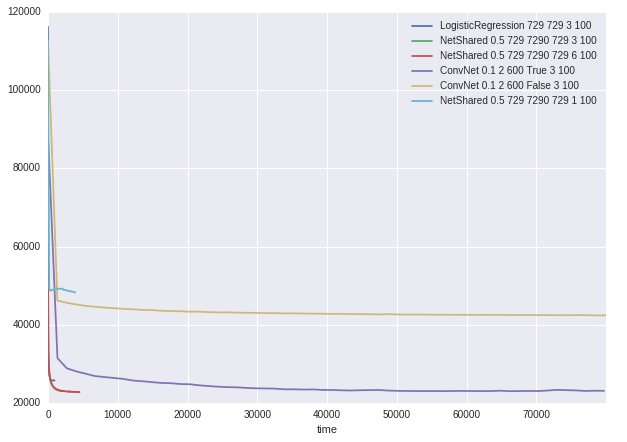

In [61]:
   
ax = None
for name, series in list(loss_results.items()):
    ax = pd.DataFrame({'loss': series, 'time': time_results[name]}).plot(
        y='loss', x='time', label=name, ax=ax)
plt.legend()    

#plt.ylim(0.05, 0.25)        

In [49]:
models.keys()

dict_keys(['LogisticRegression 729 729 3 100', 'NetShared 0.5 729 7290 729 3 100', 'NetShared 0.5 729 7290 729 6 100', 'ConvNet 0.1 3 600 True 6 100', 'ConvNet 0.1 2 600 True 3 100', 'ConvNet 0.1 2 600 False 3 100'])

In [62]:

for m_name in [x[0] for x in results]:
    #m_name = 'LogisticRegression 729 729 1 400'
    scores = []
    for puz, sln in zip(kaggle_puz, kaggle_sln):
        p = predict_puzzle(puz, models[m_name])
        score = accuracy(sln, puz, p)
        scores.append(score)
    print(m_name)
    print(scores)
    print(np.mean(scores))
    print('')

LogisticRegression 729 729 3 100
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.54716981132075471, 1.0, 0.70909090909090911, 0.37735849056603776, 0.5, 0.625, 0.9107142857142857, 0.67272727272727273, 0.43636363636363634, 0.43859649122807015, 0.32727272727272727, 0.7321428571428571, 0.39285714285714285, 0.67272727272727273, 1.0, 0.59999999999999998, 0.41818181818181815, 0.83333333333333337, 0.56000000000000005, 1.0, 1.0, 0.62264150943396224, 1.0, 0.80392156862745101]
0.739336637553

NetShared 0.5 729 7290 729 3 100
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.47169811320754718, 1.0, 0.41818181818181815, 0.39622641509433965, 0.59615384615384615, 0.375, 0.6428571428571429, 0.80000000000000004, 0.61818181818181817, 0.33333333333333331, 0.23636363636363636, 0.8214285714285714, 0.32142857142857145, 0.96363636363636362, 0.55555555555555558, 0.65454545454545454, 0.34545454545454546, 0.53703703703703709, 0.71999999999999997, 1.0, 1.0, 0.64150943396226412, 1.0, 0.72549019607843135]
0.705802728417

NetShared 0.5 729 7290 7

In [52]:
kaggle_puz_train = []
kaggle_sln_train = []
for i, line in enumerate(open('kaggle_sudoku.csv', 'r').read().splitlines()[1:400]):
    quiz, solution = line.split(",")
    kaggle_puz_train.append([int(c) for c in quiz])
    kaggle_sln_train.append([int(c) for c in solution])
    

kaggle_puz_train = np.array(kaggle_puz).reshape((-1, 9, 9))
kaggle_sln_train = np.array(kaggle_sln).reshape((-1, 9, 9))    

for m_name in models.keys():
    #m_name = 'LogisticRegression 729 729 1 400'
    scores = []
    for puz, sln in zip(kaggle_puz_train, kaggle_sln_train):
        p = predict_puzzle(puz, models[m_name])
        score = accuracy(sln, puz, p)
        scores.append(score)
    print(m_name)
    print(np.mean(scores))
    print('')

LogisticRegression 729 729 3 100
0.739336637553

NetShared 0.5 729 7290 729 3 100
0.705802728417

NetShared 0.5 729 7290 729 6 100
0.7458203688

ConvNet 0.1 3 600 True 6 100
0.656262983974

ConvNet 0.1 2 600 True 3 100
0.652182653059

ConvNet 0.1 2 600 False 3 100
0.272255247858



In [ ]:

for m_name in [x[0] for x in results]:
    #m_name = 'LogisticRegression 729 729 1 400'
    scores = []
    for puz, sln in zip(kaggle_puz, kaggle_sln):
        p = predict_puzzle(puz, models[m_name])
        score = accuracy(sln, puz, p)
        scores.append(score)
    print(m_name)
    print(scores)
    print(np.mean(scores))
    print('')

In [34]:
num_examples = 2000

dropout_prob = 0.5

for model_class in [LogisticRegression]:
        for h_size in [5 * hidden_size]:
            for epochs in [1]: 
                for batch_size in [400]:                
                    model = model_class(input_size, h_size, output_size, dropout_prob)
                    m_name = str(model) + ' {} {}'.format(epochs, batch_size)

                    models[m_name] = model
                    model.share_memory()
                    result = pool.apply_async(
                        run_training, 
                        (file_name, m_name, model, num_examples, epochs, batch_size))

                    results.append(result)

                    #result = run_training(file_name, m_name, model, num_examples, epochs)

In [36]:
list(models.keys())

['LogisticRegression 729 729 20 100',
 'LogisticRegression 729 729 20 200',
 'WideAnd2DeepNetShared 0.5 729 7290 729 20 100',
 'WideAnd2DeepNetShared 0.5 729 7290 729 20 200',
 'WideAndDeepNetShared 0.5 729 7290 729 20 100',
 'WideAndDeepNetShared 0.5 729 7290 729 20 200',
 'LogisticRegression 729 729 20 300',
 'LogisticRegression 729 729 20 400',
 'WideAndDeepNetShared 0.5 729 7290 729 20 300',
 'WideAndDeepNetShared 0.5 729 7290 729 20 400']

In [127]:
for r in results:
    print(r.get()[0] if r.ready() else False)

LogisticRegression 729 729 20 100
LogisticRegression 729 729 20 200
False
False
WideAndDeepNetShared 0.5 729 7290 729 20 100
WideAndDeepNetShared 0.5 729 7290 729 20 200
LogisticRegression 729 729 20 300
LogisticRegression 729 729 20 400
WideAndDeepNetShared 0.5 729 7290 729 20 300
WideAndDeepNetShared 0.5 729 7290 729 20 400


(0.05, 0.25)

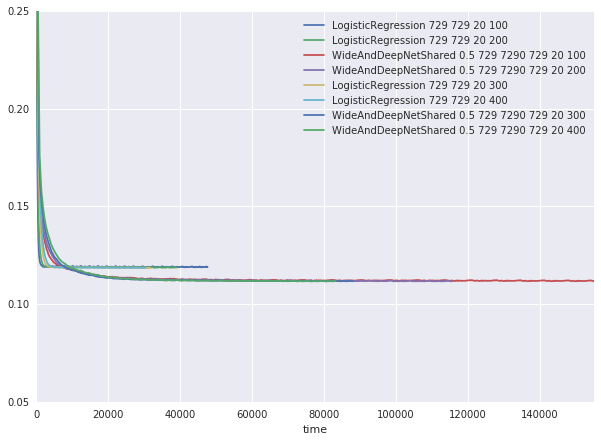

In [38]:
for r in results:
    if r.ready():
        m_name, lr, tr, model = r.get()

        loss_results[m_name] = lr
        time_results[m_name] = tr
        
ax = None
for name, series in loss_results.items():
    ax = pd.DataFrame({'loss': series, 'time': time_results[name]}).plot(
        y='loss', x='time', label=name, ax=ax)
plt.legend()    

plt.ylim(0.05, 0.25)        

(0.05, 0.25)

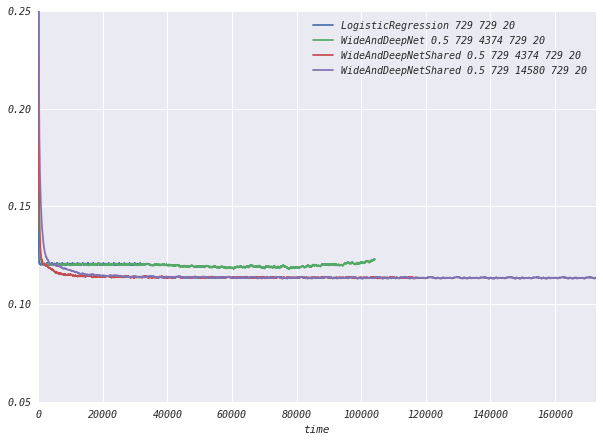

In [53]:
for r in results:
    if r.ready():
        m_name, lr, tr, model = r.get()

        loss_results[m_name] = lr
        time_results[m_name] = tr
        
ax = None
for name, series in loss_results.items():
    ax = pd.DataFrame({'loss': series, 'time': time_results[name]}).plot(
        y='loss', x='time', label=name, ax=ax)
plt.legend()    

plt.ylim(0.05, 0.25)        

In [149]:
np.array([0,0,1,0,0]).T * np.matrix(np.ones((9,9))) 

matrix([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]])

In [150]:
y[1].shape

(729,)

In [468]:
def predict(puz, model, is_only_blanks=True):
    model.eval()
    predictions = model(Variable(torch.Tensor([puz])))
    predictions = predictions[0]
    
    predictions = F.softmax(predictions.reshape((9, 81)), dim=0)
    predictions = predictions.reshape(9*81)
    
    predictions = np.array(predictions.tolist())
    min_pred = predictions.min() - 1
    
    if is_only_blanks:
        for i, e in enumerate(puz != 0):
            if e:
                predictions[i] = min_pred
                curr = i
                curr += 81
                while curr % 729 != i:
                    predictions[curr % 729] = min_pred
                    curr += 81  
        
    return predictions
    
def predict_best(puz, model):    
    predictions = predict(puz, model)
    
    ret = np.zeros(81*9, dtype=int)
        
    ret[np.argmax(predictions)] = 1  
    
    return ret


def predict_puzzle(puzzle, model):
    
    num_zeros = np.sum(puzzle == 0)
    r = matrix_to_one_hot(puzzle)
    for _ in range(num_zeros):
        pred = predict_best(r, model)
        
        r = pred + r
        
    r = one_hot_to_matrix(r)
    return r


def accuracy(answer, puzzle, prediction):
    num_zeros = np.sum(puzzle == 0)
    return ((prediction == answer).sum() - (81 - num_zeros)) / num_zeros


In [176]:
kaggle_puz = []
kaggle_sln = []
for i, line in enumerate(open('/home/spencebeecher/sudoku_kaggle_test.csv', 'r').read().splitlines()[1:]):
    quiz, solution = line.split(",")
    kaggle_puz.append([int(c) for c in quiz])
    kaggle_sln.append([int(c) for c in solution])
    

kaggle_puz = np.array(kaggle_puz).reshape((-1, 9, 9))
kaggle_sln = np.array(kaggle_sln).reshape((-1, 9, 9))

In [298]:
m_name = 'WideAndDeepNetShared 0.5 729 7290 729 20 400'
scores = []
for puz, sln in zip(kaggle_puz, kaggle_sln):
    p = predict_puzzle(puz, models[m_name])
    score = accuracy(sln, puz, p)
    scores.append(score)
print(scores)
np.mean(scores)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.36363636363636365, 0.47169811320754718, 0.59615384615384615, 0.30357142857142855, 0.39285714285714285, 1.0, 0.45454545454545453, 0.64912280701754388, 0.45454545454545453, 0.375, 0.3392857142857143, 0.72727272727272729, 0.87037037037037035, 0.59999999999999998, 1.0, 0.35185185185185186, 0.80000000000000004, 1.0, 1.0, 0.75471698113207553, 1.0, 0.92156862745098034]


0.74753989609661686

In [297]:
#with open('sudoku_big.dat', 'r') as f:
# 953, 872
with open('sudoku_eval.dat', 'r') as f:
    x, y = get_x_y(f, batches=1000)


#x, y = puz_x, puz_y
for model_name in list(models.keys()):    
    tot = 0
    for i in range(len(x)):
        r = predict_one(x[i], models[model_name])
        #print(np.sum(one_hot_to_matrix(r)==one_hot_to_matrix(y[i])))
        tot = tot + (np.sum(one_hot_to_matrix(r) == one_hot_to_matrix(y[i])) == 1)
        
    print(model_name, ' ', tot * 1.0 / len(x))

ValueError: too many values to unpack (expected 2)

In [159]:
score_puzzle(hard, sudoku.solve_puzzle(hard)[-1], models[m_name])

(0.15217391304347827, array([[9, 4, 7, 8, 1, 2, 5, 3, 6],
        [2, 3, 8, 7, 5, 6, 9, 4, 1],
        [6, 5, 1, 3, 9, 4, 7, 2, 8],
        [4, 9, 5, 6, 8, 1, 2, 7, 3],
        [1, 7, 2, 5, 3, 4, 8, 6, 9],
        [6, 8, 3, 9, 7, 7, 4, 1, 5],
        [3, 2, 4, 1, 6, 5, 6, 9, 7],
        [7, 1, 6, 2, 2, 9, 3, 5, 4],
        [5, 6, 9, 7, 4, 3, 1, 8, 2]]))

In [158]:
predict(matrix_to_one_hot(hard), models[m_name] ).astype(int)

array([-53, -13, -53, -53,   0, -13, -53, -53, -53,  -1, -53,  -1, -12,
       -53, -14, -14, -53,   0,   0, -53,  -1, -53,  -1, -14, -15,   0,
         0, -13, -53, -53, -53, -13, -53, -27, -14, -53,   0, -53,   0,
       -53, -13, -13, -14, -53,  -1, -53, -13,   0, -53, -13, -53, -13,
         0, -53, -26, -27, -26, -53, -13, -53, -29, -25, -26, -53, -53,
       -13, -24, -53, -38, -28, -53, -24, -53, -25, -53, -53, -24, -53,
       -53, -11, -53, -53,   0, -53, -53, -15,   0, -53, -53, -53,  -1,
       -53,  -1,   0, -53,   0,   0, -53, -14,  -2, -53,  -1, -53, -17,
        -1,  -1,  -1, -14,  -1, -53, -53, -53, -13, -53,   0,   0, -53,
        -1, -53,  -2, -53, -15,   0,   0, -53, -14, -53,   0,  -1, -53,
       -14, -53,   0,   0, -53,   0,   0,   0, -53, -14, -53, -15, -13,
       -14, -53, -53, -14, -12, -53, -14, -27, -53, -27, -53, -12, -53,
       -53, -27, -53, -53, -13, -53, -53, -25, -53, -53, -24, -37, -53,
       -53, -53, -12, -53, -13, -24, -53, -38, -25, -53, -38, -2

In [135]:
predict(matrix_to_one_hot(np.array([[9, 4, 7, 8, 1, 2, 5, 3, 6],
        [2, 3, 8, 0, 7, 6, 9, 4, 1],
        [0, 5, 6, 4, 9, 0, 7, 2, 8],
        [4, 9, 5, 6, 8, 1, 2, 7, 3],
        [1, 7, 2, 5, 3, 4, 8, 6, 9],
        [6, 8, 3, 9, 0, 7, 4, 1, 5],
        [8, 2, 4, 1, 6, 5, 0, 9, 7],
        [7, 1, 0, 0, 2, 9, 6, 5, 4],
        [5, 6, 9, 7, 4, 3, 1, 8, 2]])), models[m_name], False ).astype(int)

array([-38, -39, -24, -37,  17, -37, -49, -50, -38, -39, -38, -24, -36,
       -41, -51, -37, -38,  17, -10, -24,  -8, -40, -25, -23, -38, -37,
       -24, -37, -50, -37, -36, -36,  18, -49, -37, -49,  17, -37, -24,
       -49, -49, -36, -49, -37, -49, -37, -50, -37, -52, -35, -37, -37,
        18, -36, -51, -38, -37,  18, -37, -37, -24, -49, -49, -39,  17,
       -10, -23, -49, -52, -38, -48, -49, -50, -37, -36, -37, -48, -49,
        17, -36, -36, -36, -49, -48, -24, -38,  17, -49, -36, -49,  18,
       -37, -36, -23, -53, -37, -49, -36, -49, -23, -48, -51, -40, -50,
       -24, -37,  18, -36, -50, -49, -37, -24, -39, -40,  17, -37, -37,
       -37, -38,  16, -24, -38, -39, -37, -49, -49, -36, -36, -24,  -8,
       -10, -23, -25, -36, -38, -38,  18, -36, -37, -37, -50, -36, -49,
       -36, -49, -36, -36, -11,  17, -40, -49, -49, -37, -49, -36, -49,
       -37, -37, -49, -36, -36,  18, -38, -38, -51, -24, -38, -38, -26,
        16, -38, -24,  15, -38, -11, -42, -38, -37, -38, -51, -1

In [120]:
sudoku.is_correct(sudoku.solve_puzzle(hard)[-1])

True

In [99]:
hard = np.array([
       [9, 0, 7, 8, 0, 0, 5, 3, 6],
       [0, 3, 0, 0, 5, 0, 0, 4, 0],
       [0, 5, 0, 3, 0, 0, 0, 0, 0],
       [0, 9, 5, 6, 0, 1, 0, 0, 3],
       [0, 7, 0, 5, 0, 0, 0, 6, 0],
       [6, 0, 0, 9, 0, 7, 0, 0, 5],
       [0, 0, 0, 1, 0, 5, 0, 0, 0],
       [7, 1, 0, 0, 2, 0, 0, 5, 0],
       [5, 0, 9, 7, 0, 3, 1, 0, 2]])

-inf

In [95]:


puzz = predict_one(matrix_to_one_hot(hard), models[m_name], n=0)
puzz = one_hot_to_matrix(puzz)
display(puzz)
print()

solved = sudoku.solve_puzzle(hard)[-1]
display(solved)

if np.any(solved==puzz):
    hard = hard+puzz
    print('correct!')

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 3, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

array([[9, 2, 7, 8, 1, 4, 5, 3, 6],
       [1, 3, 6, 2, 5, 9, 8, 4, 7],
       [8, 5, 4, 3, 7, 6, 2, 9, 1],
       [4, 9, 5, 6, 8, 1, 7, 2, 3],
       [3, 7, 1, 5, 4, 2, 9, 6, 8],
       [6, 8, 2, 9, 3, 7, 4, 1, 5],
       [2, 6, 8, 1, 9, 5, 3, 7, 4],
       [7, 1, 3, 4, 2, 8, 6, 5, 9],
       [5, 4, 9, 7, 6, 3, 1, 8, 2]])

In [96]:
hard

array([[9, 0, 7, 8, 0, 0, 5, 3, 6],
       [0, 3, 0, 0, 5, 0, 0, 4, 0],
       [0, 5, 0, 3, 0, 0, 0, 0, 0],
       [0, 9, 5, 6, 0, 1, 0, 0, 3],
       [0, 7, 0, 5, 0, 0, 0, 6, 0],
       [6, 0, 0, 9, 0, 7, 0, 0, 5],
       [0, 0, 0, 1, 0, 5, 0, 0, 0],
       [7, 1, 0, 0, 2, 0, 0, 5, 0],
       [5, 0, 9, 7, 0, 3, 1, 0, 2]])

In [ ]:
WideAndDeepNet 0.5 729 1458 729 5 False   0.079
WideAndDeepNetShared 0.5 729 1458 729 5 False   0.078
NetShared 0.5 729 1458 729 5 False   0.066
WideAndDeepNet 0.5 729 1458 729 5 True   0.88
WideAndDeepNetShared 0.5 729 1458 729 5 True   0.941
NetShared 0.5 729 1458 729 5 True   0.942
WideAndDeepNet 0.5 729 2916 729 5 True   0.864
WideAndDeepNet 0.5 729 7290 729 5 True   0.869
WideAndDeepNetShared 0.5 729 2916 729 5 True   0.958
WideAndDeepNetShared 0.5 729 7290 729 5 True   0.968
NetShared 0.5 729 2916 729 5 True   0.946
NetShared 0.5 729 7290 729 5 True   0.968
WideAndDeepNetShared 0.5 729 1458 729 1 False   0.067

In [40]:
hidden_size*5

7290

In [46]:
#with open('sudoku_big.dat', 'r') as f:
# 953, 872
with open('sudoku_eval.dat', 'r') as f:
    x, y = get_x_y(f, batches=1000)


#x, y = puz_x, puz_y
for model_name in list(models.keys()):    
    tot = 0
    n = 0
    for i in range(len(x)):
        r = ml_solve_puzzle_answer(x[i], models[model_name], y[i])
        #print(np.sum(one_hot_to_matrix(r)==one_hot_to_matrix(y[i])))
        tot = tot + (one_hot_to_matrix(r) == one_hot_to_matrix(y[i])).sum() / 81.0
        n = n + 1
        
    print(model_name, ' ', tot * 1.0 / n)

NameError: name 'ml_solve_puzzle_answer' is not defined

In [47]:
def ml_solve_puzzle_answer(puz, model, answer=None):
    #answer = one_hot_to_matrix(answer)
    num_zeros = np.sum(one_hot_to_matrix(puz) == 0)
    curr_puz = puz.copy()
    
    i = 0 
    while num_zeros > 0 and i < 90:
        #print(i)
        pred = predict_one(curr_puz, model, 0)
        
        if not answer is None and not (answer & pred).sum() == 1:
            return curr_puz
        
        curr_puz += pred
        
        parr = one_hot_to_matrix(curr_puz)
        
        num_zeros = np.sum(parr == 0)
        i += 1
        
    return curr_puz

In [224]:
i = 8
model = models['WideAndDeepNetShared 0.5 729 4374 729 20 True']

r = ml_solve_puzzle_answer(
        x[i], 
        model,
        y[i]
    )



#print((one_hot_to_matrix(y[i]) == one_hot_to_matrix(r)) | (one_hot_to_matrix(r) == 0))
#print(one_hot_to_matrix(x[i]))
#print()

print(one_hot_to_matrix(y[i]))
print()


print(one_hot_to_matrix(r))
print()    

print(one_hot_to_matrix(predict_one(r, model, 0)))

[[8 2 3 9 5 7 1 4 6]
 [7 6 5 8 1 4 2 3 9]
 [4 9 1 6 3 2 8 5 7]
 [1 4 6 2 7 9 3 8 5]
 [5 7 8 3 4 6 9 2 1]
 [9 3 2 5 8 1 7 6 4]
 [2 1 9 4 6 8 5 7 3]
 [3 8 4 7 9 5 6 1 2]
 [6 5 7 1 2 3 4 9 8]]

[[0 0 0 0 0 0 0 0 0]
 [0 6 5 8 1 4 0 0 0]
 [0 0 1 0 0 2 0 0 7]
 [0 0 0 0 0 0 0 0 0]
 [5 7 8 3 0 6 0 0 1]
 [0 3 0 5 8 1 7 0 4]
 [0 1 9 0 0 8 0 7 3]
 [0 8 4 7 0 5 0 1 2]
 [0 5 7 1 2 0 0 9 8]]

[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 7 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]


In [164]:
rr

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [157]:
print(one_hot_to_matrix(x[i]))
print()
print(one_hot_to_matrix(y[i]))
print()



print(one_hot_to_matrix(predict_one(x[i], model, 2)))
print()
print(one_hot_to_matrix(predict_one(x[i], model, 1)))
print()
print(one_hot_to_matrix(predict_one(x[i], model, 0)))

[[0 0 7 0 2 0 0 9 8]
 [0 0 4 7 0 5 0 1 2]
 [0 1 9 0 0 0 0 7 3]
 [0 3 0 5 8 1 0 0 4]
 [5 7 8 3 0 6 0 0 1]
 [0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 2 0 0 7]
 [0 6 5 8 1 4 0 0 0]
 [0 0 0 0 0 0 0 0 0]]

[[6 5 7 1 2 3 4 9 8]
 [3 8 4 7 9 5 6 1 2]
 [2 1 9 4 6 8 5 7 3]
 [9 3 2 5 8 1 7 6 4]
 [5 7 8 3 4 6 9 2 1]
 [1 4 6 2 7 9 3 8 5]
 [4 9 1 6 3 2 8 5 7]
 [7 6 5 8 1 4 2 3 9]
 [8 2 3 9 5 7 1 4 6]]

[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 8 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]

[[0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]

[[0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]


In [147]:
for rr in predict_one(x[i], model, 3):
    print(one_hot_to_matrix(rr))
    print('')   

[[0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]

[[0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]

[[0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]



In [118]:
i = 4

puz = one_hot_to_matrix(x[i])

res = one_hot_to_matrix(
    ml_solve_puzzle_answer(
        matrix_to_one_hot(puz), 
        models['WideAndDeepNetShared 0.5 729 4374 729 20 True'],
        y[i]
    )
        
        
)

display(one_hot_to_matrix(x[i]))
print()
display(one_hot_to_matrix(y[i]))
print()
display(res)

display(number_match(matrix_to_one_hot(puz), matrix_to_one_hot(res)))


ValueError: operands could not be broadcast together with shapes (9,9) (729,) 

In [101]:
one_hot_to_matrix(y[i]) == res

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True]], dtype=bool)

In [103]:
number_match(matrix_to_one_hot(res), y[i])

81

In [102]:
number_match(y[i], matrix_to_one_hot(res))

81

In [ ]:
def number_match(guess, answer):
    return (one_hot_to_matrix(guess) == one_hot_to_matrix(answer)).sum() 

In [ ]:
#def predict(puz, model):
#    model.eval()
#    predictions = model(Variable(torch.Tensor([puz])))
#    predictions = np.array(predictions[0].tolist())
#    return argmax_to_matrix(predictions)



In [163]:
for i in range(len(y)):
    if not np.all(matrix_to_one_hot(one_hot_to_matrix(y[i])) == y[i]):
        print("bad")
        break
        
    if not np.all(one_hot_to_matrix(matrix_to_one_hot(one_hot_to_matrix(y[i]))) == one_hot_to_matrix(y[i])):
        print("bad")
        break        

In [164]:
sudoku.is_complete(one_hot_to_matrix(y[0])) and sudoku.is_correct(one_hot_to_matrix(y[0]))

True

In [153]:
sudoku.solve_puzzle(one_hot_to_matrix(x[0]))

[array([[6, 4, 1, 7, 5, 9, 3, 2, 8],
        [9, 3, 2, 4, 1, 8, 5, 6, 7],
        [7, 5, 8, 2, 3, 6, 1, 9, 4],
        [5, 8, 3, 9, 7, 2, 6, 4, 1],
        [1, 2, 9, 6, 4, 3, 8, 7, 5],
        [4, 6, 7, 1, 8, 5, 2, 3, 9],
        [3, 7, 5, 8, 6, 4, 9, 1, 2],
        [2, 1, 6, 5, 9, 7, 4, 8, 3],
        [8, 9, 4, 3, 2, 1, 7, 5, 6]])]

In [85]:
with open('sudoku_eval.dat', 'r') as f:
    x, y = get_x_y(f, batches=1000)


#x, y = puz_x, puz_y
for model_name in models.keys():    
    tot = 0
    for i in range(len(x)):
        r = predict_one(x[i], models[model_name])
        #print(np.sum(one_hot_to_matrix(r)==one_hot_to_matrix(y[i])))
        tot = tot + (np.sum(one_hot_to_matrix(r) == one_hot_to_matrix(y[i])) == 1)
        
    print(model_name, ' ', tot * 1.0 / len(x))
    

wideanddeepnet 2917   0.877


In [69]:
with open('sudoku_eval.dat', 'r') as f:
    x, y = get_x_y(f, batches=1000)


#x, y = puz_x, puz_y
for model_name in models.keys():    
    tot = 0
    for i in range(len(x)):
        r = predict_one(x[i], models[model_name])
        #print(np.sum(one_hot_to_matrix(r)==one_hot_to_matrix(y[i])))
        tot = tot + (np.sum(one_hot_to_matrix(r) == one_hot_to_matrix(y[i])) == 1)
        
    print(model_name, ' ', tot * 1.0 / len(x))
    

wideanddeepnet 1458   0.837


In [97]:
with open('sudoku_eval.dat', 'r') as f:
    x, y = get_x_y(f, batches=1000)


#x, y = puz_x, puz_y
for model_name in models.keys():    
    tot = 0
    for i in range(len(x)):
        r = predict(x[i], models[model_name])
        #print(np.sum(one_hot_to_matrix(r)==one_hot_to_matrix(y[i])))
        tot = tot + (np.sum(r == one_hot_to_matrix(y[i])))
        display(r)
        break
    print(model_name, ' ', tot * 1.0 / len(x))
    

array([[6, 2, 1, 7, 5, 6, 2, 4, 7],
       [9, 2, 2, 7, 7, 9, 3, 2, 7],
       [6, 8, 8, 3, 5, 6, 3, 4, 8],
       [5, 3, 8, 7, 7, 2, 6, 4, 1],
       [9, 2, 9, 9, 4, 4, 2, 4, 4],
       [6, 2, 7, 7, 7, 2, 6, 9, 6],
       [5, 4, 4, 8, 4, 4, 2, 5, 8],
       [6, 6, 6, 8, 9, 9, 3, 8, 8],
       [5, 4, 4, 3, 4, 1, 3, 5, 3]])

wideanddeepnet 1458   0.028


array([[6, 2, 1, 7, 5, 6, 2, 4, 7],
       [9, 2, 2, 7, 7, 9, 3, 2, 7],
       [6, 8, 8, 3, 5, 6, 3, 4, 8],
       [5, 3, 8, 7, 7, 2, 6, 4, 1],
       [9, 2, 9, 9, 4, 4, 2, 4, 4],
       [6, 2, 7, 7, 7, 2, 6, 9, 6],
       [5, 4, 4, 8, 4, 4, 2, 5, 8],
       [6, 6, 6, 8, 9, 9, 3, 8, 8],
       [5, 4, 4, 3, 3, 1, 3, 5, 3]])

wideanddeepnet 729.0   0.028


array([[9, 8, 1, 9, 4, 6, 8, 5, 5],
       [8, 9, 5, 7, 3, 7, 6, 4, 5],
       [1, 7, 9, 3, 5, 7, 6, 2, 1],
       [3, 8, 3, 5, 9, 2, 9, 4, 6],
       [9, 4, 4, 4, 2, 5, 1, 9, 4],
       [9, 2, 8, 2, 3, 1, 2, 4, 6],
       [6, 1, 5, 4, 4, 3, 9, 4, 5],
       [4, 5, 3, 5, 4, 7, 5, 5, 5],
       [9, 3, 4, 8, 7, 5, 2, 9, 4]])

wideanddeepnet 2916   0.011


array([[6, 2, 1, 7, 5, 6, 2, 4, 7],
       [9, 2, 2, 7, 7, 9, 3, 2, 7],
       [6, 8, 8, 3, 5, 6, 3, 4, 8],
       [5, 3, 8, 7, 7, 2, 6, 4, 1],
       [9, 2, 9, 9, 4, 4, 2, 4, 4],
       [6, 2, 7, 7, 7, 2, 6, 9, 6],
       [5, 4, 4, 8, 4, 4, 2, 5, 8],
       [6, 6, 6, 8, 9, 9, 3, 8, 8],
       [5, 4, 4, 3, 3, 1, 3, 5, 3]])

wideanddeepnet 14580   0.028


array([[6, 2, 1, 7, 5, 6, 2, 4, 7],
       [9, 2, 2, 7, 7, 9, 3, 2, 7],
       [6, 8, 8, 3, 5, 6, 3, 4, 8],
       [5, 3, 8, 7, 7, 2, 6, 4, 1],
       [9, 2, 9, 9, 4, 4, 2, 4, 4],
       [6, 2, 7, 7, 7, 2, 6, 9, 6],
       [5, 4, 4, 8, 4, 4, 2, 5, 8],
       [6, 6, 6, 8, 9, 9, 3, 8, 8],
       [5, 4, 4, 3, 3, 1, 3, 5, 3]])

wideanddeepnet 2917   0.028


In [98]:
threshold = 0

with open('sudoku_eval.dat', 'r') as f:
    x, y = get_x_y(f, batches=1000)



#x, y = puz_x, puz_y
for model_name in models.keys():    
    tot = 0
    print(model_name)
    for i in range(len(x)):
        r = predict_one(x[i], models[model_name])
        #print(np.sum(one_hot_to_matrix(r)==one_hot_to_matrix(y[i])))
        is_correct = (np.sum(one_hot_to_matrix(r) == one_hot_to_matrix(y[i])) == 1)
        if is_correct and np.random.rand() > threshold:
            print(i)
            display(one_hot_to_matrix(r))
            print('')    
            display(one_hot_to_matrix(x[i]))
            print('')    
            display(one_hot_to_matrix(y[i]))            
            break
    print('')    
    print('')        
    print('')        
    print('')       
    for i in range(len(x)):
        r = predict_one(x[i], models[model_name])
        #print(np.sum(one_hot_to_matrix(r)==one_hot_to_matrix(y[i])))
        is_correct = (np.sum(one_hot_to_matrix(r) == one_hot_to_matrix(y[i])) == 1)
        if not is_correct and np.random.rand() > threshold:
            print(i)
            display(one_hot_to_matrix(r))
            print('')    
            display(one_hot_to_matrix(x[i]))
            print('')    
            display(one_hot_to_matrix(y[i]))           
            break    
            
    print('')        
    print('')        
    print('')                
#    print(model_name, ' ', tot * 1.0 / len(x))
    

wideanddeepnet 1458
13


array([[0, 2, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

array([[0, 0, 4, 0, 0, 1, 0, 8, 5],
       [6, 0, 9, 3, 0, 8, 0, 4, 0],
       [0, 8, 0, 4, 0, 0, 0, 3, 2],
       [2, 0, 8, 0, 4, 0, 0, 0, 7],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 6, 0, 2, 5, 0, 0, 0, 9],
       [0, 0, 2, 5, 9, 0, 0, 0, 3],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 9, 7, 0, 0, 2, 0, 0, 4]])

array([[3, 2, 4, 9, 7, 1, 6, 8, 5],
       [6, 5, 9, 3, 2, 8, 7, 4, 1],
       [7, 8, 1, 4, 6, 5, 9, 3, 2],
       [2, 1, 8, 6, 4, 9, 3, 5, 7],
       [9, 7, 5, 1, 8, 3, 4, 2, 6],
       [4, 6, 3, 2, 5, 7, 8, 1, 9],
       [8, 4, 2, 5, 9, 6, 1, 7, 3],
       [5, 3, 6, 7, 1, 4, 2, 9, 8],
       [1, 9, 7, 8, 3, 2, 5, 6, 4]])





0


array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 6, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 4, 1, 8, 5, 6, 0],
       [7, 0, 0, 2, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 6, 0, 3, 8, 7, 5],
       [4, 0, 0, 1, 8, 5, 0, 3, 0],
       [3, 7, 0, 0, 0, 0, 9, 1, 0],
       [2, 1, 0, 5, 0, 7, 4, 0, 0],
       [8, 9, 0, 0, 2, 0, 7, 0, 0]])

array([[6, 4, 1, 7, 5, 9, 3, 2, 8],
       [9, 3, 2, 4, 1, 8, 5, 6, 7],
       [7, 5, 8, 2, 3, 6, 1, 9, 4],
       [5, 8, 3, 9, 7, 2, 6, 4, 1],
       [1, 2, 9, 6, 4, 3, 8, 7, 5],
       [4, 6, 7, 1, 8, 5, 2, 3, 9],
       [3, 7, 5, 8, 6, 4, 9, 1, 2],
       [2, 1, 6, 5, 9, 7, 4, 8, 3],
       [8, 9, 4, 3, 2, 1, 7, 5, 6]])




wideanddeepnet 729.0
13


array([[0, 2, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

array([[0, 0, 4, 0, 0, 1, 0, 8, 5],
       [6, 0, 9, 3, 0, 8, 0, 4, 0],
       [0, 8, 0, 4, 0, 0, 0, 3, 2],
       [2, 0, 8, 0, 4, 0, 0, 0, 7],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 6, 0, 2, 5, 0, 0, 0, 9],
       [0, 0, 2, 5, 9, 0, 0, 0, 3],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 9, 7, 0, 0, 2, 0, 0, 4]])

array([[3, 2, 4, 9, 7, 1, 6, 8, 5],
       [6, 5, 9, 3, 2, 8, 7, 4, 1],
       [7, 8, 1, 4, 6, 5, 9, 3, 2],
       [2, 1, 8, 6, 4, 9, 3, 5, 7],
       [9, 7, 5, 1, 8, 3, 4, 2, 6],
       [4, 6, 3, 2, 5, 7, 8, 1, 9],
       [8, 4, 2, 5, 9, 6, 1, 7, 3],
       [5, 3, 6, 7, 1, 4, 2, 9, 8],
       [1, 9, 7, 8, 3, 2, 5, 6, 4]])





0


array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 6, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 4, 1, 8, 5, 6, 0],
       [7, 0, 0, 2, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 6, 0, 3, 8, 7, 5],
       [4, 0, 0, 1, 8, 5, 0, 3, 0],
       [3, 7, 0, 0, 0, 0, 9, 1, 0],
       [2, 1, 0, 5, 0, 7, 4, 0, 0],
       [8, 9, 0, 0, 2, 0, 7, 0, 0]])

array([[6, 4, 1, 7, 5, 9, 3, 2, 8],
       [9, 3, 2, 4, 1, 8, 5, 6, 7],
       [7, 5, 8, 2, 3, 6, 1, 9, 4],
       [5, 8, 3, 9, 7, 2, 6, 4, 1],
       [1, 2, 9, 6, 4, 3, 8, 7, 5],
       [4, 6, 7, 1, 8, 5, 2, 3, 9],
       [3, 7, 5, 8, 6, 4, 9, 1, 2],
       [2, 1, 6, 5, 9, 7, 4, 8, 3],
       [8, 9, 4, 3, 2, 1, 7, 5, 6]])




wideanddeepnet 2916
0


array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 8, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 4, 1, 8, 5, 6, 0],
       [7, 0, 0, 2, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 6, 0, 3, 8, 7, 5],
       [4, 0, 0, 1, 8, 5, 0, 3, 0],
       [3, 7, 0, 0, 0, 0, 9, 1, 0],
       [2, 1, 0, 5, 0, 7, 4, 0, 0],
       [8, 9, 0, 0, 2, 0, 7, 0, 0]])

array([[6, 4, 1, 7, 5, 9, 3, 2, 8],
       [9, 3, 2, 4, 1, 8, 5, 6, 7],
       [7, 5, 8, 2, 3, 6, 1, 9, 4],
       [5, 8, 3, 9, 7, 2, 6, 4, 1],
       [1, 2, 9, 6, 4, 3, 8, 7, 5],
       [4, 6, 7, 1, 8, 5, 2, 3, 9],
       [3, 7, 5, 8, 6, 4, 9, 1, 2],
       [2, 1, 6, 5, 9, 7, 4, 8, 3],
       [8, 9, 4, 3, 2, 1, 7, 5, 6]])





1


array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 9, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 6, 5, 8, 1, 4, 0, 0, 0],
       [0, 0, 1, 0, 0, 2, 0, 0, 7],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [5, 7, 8, 3, 0, 6, 0, 0, 1],
       [0, 3, 0, 5, 8, 1, 0, 0, 4],
       [0, 1, 9, 0, 0, 0, 0, 7, 3],
       [0, 0, 4, 7, 0, 5, 0, 1, 2],
       [0, 0, 7, 0, 2, 0, 0, 9, 8]])

array([[8, 2, 3, 9, 5, 7, 1, 4, 6],
       [7, 6, 5, 8, 1, 4, 2, 3, 9],
       [4, 9, 1, 6, 3, 2, 8, 5, 7],
       [1, 4, 6, 2, 7, 9, 3, 8, 5],
       [5, 7, 8, 3, 4, 6, 9, 2, 1],
       [9, 3, 2, 5, 8, 1, 7, 6, 4],
       [2, 1, 9, 4, 6, 8, 5, 7, 3],
       [3, 8, 4, 7, 9, 5, 6, 1, 2],
       [6, 5, 7, 1, 2, 3, 4, 9, 8]])




wideanddeepnet 14580
13


array([[0, 2, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

array([[0, 0, 4, 0, 0, 1, 0, 8, 5],
       [6, 0, 9, 3, 0, 8, 0, 4, 0],
       [0, 8, 0, 4, 0, 0, 0, 3, 2],
       [2, 0, 8, 0, 4, 0, 0, 0, 7],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 6, 0, 2, 5, 0, 0, 0, 9],
       [0, 0, 2, 5, 9, 0, 0, 0, 3],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 9, 7, 0, 0, 2, 0, 0, 4]])

array([[3, 2, 4, 9, 7, 1, 6, 8, 5],
       [6, 5, 9, 3, 2, 8, 7, 4, 1],
       [7, 8, 1, 4, 6, 5, 9, 3, 2],
       [2, 1, 8, 6, 4, 9, 3, 5, 7],
       [9, 7, 5, 1, 8, 3, 4, 2, 6],
       [4, 6, 3, 2, 5, 7, 8, 1, 9],
       [8, 4, 2, 5, 9, 6, 1, 7, 3],
       [5, 3, 6, 7, 1, 4, 2, 9, 8],
       [1, 9, 7, 8, 3, 2, 5, 6, 4]])





0


array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 6, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 4, 1, 8, 5, 6, 0],
       [7, 0, 0, 2, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 6, 0, 3, 8, 7, 5],
       [4, 0, 0, 1, 8, 5, 0, 3, 0],
       [3, 7, 0, 0, 0, 0, 9, 1, 0],
       [2, 1, 0, 5, 0, 7, 4, 0, 0],
       [8, 9, 0, 0, 2, 0, 7, 0, 0]])

array([[6, 4, 1, 7, 5, 9, 3, 2, 8],
       [9, 3, 2, 4, 1, 8, 5, 6, 7],
       [7, 5, 8, 2, 3, 6, 1, 9, 4],
       [5, 8, 3, 9, 7, 2, 6, 4, 1],
       [1, 2, 9, 6, 4, 3, 8, 7, 5],
       [4, 6, 7, 1, 8, 5, 2, 3, 9],
       [3, 7, 5, 8, 6, 4, 9, 1, 2],
       [2, 1, 6, 5, 9, 7, 4, 8, 3],
       [8, 9, 4, 3, 2, 1, 7, 5, 6]])




wideanddeepnet 2917
13


array([[0, 2, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

array([[0, 0, 4, 0, 0, 1, 0, 8, 5],
       [6, 0, 9, 3, 0, 8, 0, 4, 0],
       [0, 8, 0, 4, 0, 0, 0, 3, 2],
       [2, 0, 8, 0, 4, 0, 0, 0, 7],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 6, 0, 2, 5, 0, 0, 0, 9],
       [0, 0, 2, 5, 9, 0, 0, 0, 3],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 9, 7, 0, 0, 2, 0, 0, 4]])

array([[3, 2, 4, 9, 7, 1, 6, 8, 5],
       [6, 5, 9, 3, 2, 8, 7, 4, 1],
       [7, 8, 1, 4, 6, 5, 9, 3, 2],
       [2, 1, 8, 6, 4, 9, 3, 5, 7],
       [9, 7, 5, 1, 8, 3, 4, 2, 6],
       [4, 6, 3, 2, 5, 7, 8, 1, 9],
       [8, 4, 2, 5, 9, 6, 1, 7, 3],
       [5, 3, 6, 7, 1, 4, 2, 9, 8],
       [1, 9, 7, 8, 3, 2, 5, 6, 4]])





0


array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 6, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 4, 1, 8, 5, 6, 0],
       [7, 0, 0, 2, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 6, 0, 3, 8, 7, 5],
       [4, 0, 0, 1, 8, 5, 0, 3, 0],
       [3, 7, 0, 0, 0, 0, 9, 1, 0],
       [2, 1, 0, 5, 0, 7, 4, 0, 0],
       [8, 9, 0, 0, 2, 0, 7, 0, 0]])

array([[6, 4, 1, 7, 5, 9, 3, 2, 8],
       [9, 3, 2, 4, 1, 8, 5, 6, 7],
       [7, 5, 8, 2, 3, 6, 1, 9, 4],
       [5, 8, 3, 9, 7, 2, 6, 4, 1],
       [1, 2, 9, 6, 4, 3, 8, 7, 5],
       [4, 6, 7, 1, 8, 5, 2, 3, 9],
       [3, 7, 5, 8, 6, 4, 9, 1, 2],
       [2, 1, 6, 5, 9, 7, 4, 8, 3],
       [8, 9, 4, 3, 2, 1, 7, 5, 6]])

In [49]:
from importlib import reload
reload(sudoku)

i = 0

mtx = one_hot_to_matrix(x[i])
sln = one_hot_to_matrix(y[i])

print('matrix')
display(mtx)

print('\nsolution')
display(sln)


print('is solution correct ', sudoku.is_complete(sln) and sudoku.is_correct(sln))

print('algorithmic solutions')
display(sudoku.solve_step(mtx))

display(sudoku.get_possibilities(mtx)[1,2])

display(np.all(sudoku.solve_puzzle(mtx)[0] == sln))

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 4, 1, 8, 5, 6, 0],
       [7, 0, 0, 2, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 6, 0, 3, 8, 7, 5],
       [4, 0, 0, 1, 8, 5, 0, 3, 0],
       [3, 7, 0, 0, 0, 0, 9, 1, 0],
       [2, 1, 0, 5, 0, 7, 4, 0, 0],
       [8, 9, 0, 0, 2, 0, 7, 0, 0]])

array([[6, 4, 1, 7, 5, 9, 3, 2, 8],
       [9, 3, 2, 4, 1, 8, 5, 6, 7],
       [7, 5, 8, 2, 3, 6, 1, 9, 4],
       [5, 8, 3, 9, 7, 2, 6, 4, 1],
       [1, 2, 9, 6, 4, 3, 8, 7, 5],
       [4, 6, 7, 1, 8, 5, 2, 3, 9],
       [3, 7, 5, 8, 6, 4, 9, 1, 2],
       [2, 1, 6, 5, 9, 7, 4, 8, 3],
       [8, 9, 4, 3, 2, 1, 7, 5, 6]])

True
True


array([[0, 0, 1, 0, 0, 0, 3, 0, 0],
       [9, 0, 0, 0, 0, 0, 0, 0, 7],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 0, 0, 1],
       [0, 2, 0, 0, 4, 0, 0, 0, 0],
       [0, 0, 7, 0, 0, 0, 0, 0, 0],
       [0, 0, 5, 8, 0, 0, 0, 0, 2],
       [0, 0, 6, 0, 9, 0, 0, 8, 0],
       [0, 0, 0, 3, 0, 1, 0, 5, 0]])

{2, 3, 9}

True

In [ ]:
# do an eval with full matrix prediction